<a href="https://colab.research.google.com/github/grace3999/BB_projects/blob/master/MouseOx_cage.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#mount google drive containings required files: 1) csv of annotation features, 2) netcdf files
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
#getting and working with data
import pandas as pd
import numpy as np
import re
import os
import datetime as dt
import string
import scipy

#visualizing results
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_context("poster")
sns.set_style("ticks")

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 15000)
pd.set_option('display.max_colwidth', None)

import warnings; warnings.simplefilter('ignore')
np.set_printoptions(suppress=True)

### Plan on attack!

- read in folder containing data files
- for each data file
    - clean (update column names, drop first 2 rows with param metadata)
- for final data frame
    - reset_index for each animal separately (so have same time series)
    - update data types
    - filter out bad data (use error codes)
    
- questions to figure out
    - are some error codes more common at beginning of recording etc


### Analysis plan!

- previous pubs:
    - bin by 5 min
        - can be raw or fold change (some show both)
- for us:
    - is there autonomic differences immediately coming out of iso in sham vs. blast
        - compare first 30, 60, 90 seconds 
        - compare rate of change
    - is there autonomic differences immediately after LORR recovery in sham vs. blast
        - compare first 30, 60, 90 seconds 
            - normalize to initial 30 seconds out of iso?
            - normalize to final 30 seconds before LORR flip?
    - are there differences between sham vs. blast in awake baseline compared to exposure iso

### Get and clean data

In [3]:
path = '/content/gdrive/Shareddrives/Schindler Lab/data/MouseOx/data/TXT3'

files = os.listdir(path)

data_file_paths = []
for file in files:
    file_path = path + '/' + file
    data_file_paths.append(file_path)

print(len(data_file_paths))
data_file_paths[0:5]

7


['/content/gdrive/Shareddrives/Schindler Lab/data/MouseOx/data/TXT3/SA376_210507_TXT_3.txt',
 '/content/gdrive/Shareddrives/Schindler Lab/data/MouseOx/data/TXT3/SA377_210507_TXT_3.txt',
 '/content/gdrive/Shareddrives/Schindler Lab/data/MouseOx/data/TXT3/SA378_210507_TXT_3.txt',
 '/content/gdrive/Shareddrives/Schindler Lab/data/MouseOx/data/TXT3/SA379_210507_TXT_3.txt',
 '/content/gdrive/Shareddrives/Schindler Lab/data/MouseOx/data/TXT3/SA380_210514_TXT_3.txt']

In [7]:
meta_path =  '/content/gdrive/Shareddrives/Schindler Lab/data/MouseOx/MO_VNS_AcuteL.xlsx'

data_meta = pd.read_excel(meta_path) 
data_meta = pd.DataFrame(data = data_meta)

data_meta['animal'] = data_meta['animal'].astype(int).astype('str')
data_meta['day'] = data_meta['day'].astype('str')
data_meta['date'] = data_meta['date'].dt.date

print(data_meta.shape)
data_meta.head()

(102, 9)


,animal,group,cohort,date,phase,day,start,flip,end
0,1359,SS,1,2021-05-05,EX,1,1,2,3
1,1359,SS,1,2021-05-06,EX,2,1,2,3
2,1359,SS,1,2021-05-07,EX,3,1,2,3
3,1359,SS,1,2021-05-05,TXT,1,1,3,5
4,1359,SS,1,2021-05-06,TXT,2,1,2,3


In [12]:
final_data = pd.DataFrame()

marker_time = 450 #30 seconds at 15 hz

for file in data_file_paths:
    print(file)
    
    if file.split('/')[-1] == '.DS_Store':
        continue
     
    #get file meta data
    cage = file.split('/')[-1].split('_')[0]
    #date = file.split('/')[-1].split('_')[1]
    phase = file.split('/')[-1].split('_')[2]
    day = file.split('/')[-1].split('_')[3].split('.')[0]

    #make dataframe
    data_int = pd.read_table(file, sep=',') 
    data_int = pd.DataFrame(data = data_int)
    
    #drop un used columns
    data_int = data_int.drop(['Core', '15Hz'], axis=1)
    
    #update columns names
    data_int.columns = ['time_sec', 'animal', 'animal_count', 'file_marker', 'error_code', 
                        'O2_sat', 'hr_bpm', 'br_brpm', 'pd_um', 'bd_um', 'activity', 'datetime']
    
    #drop rows with param meta data
    data_int = data_int.drop([0, 1], axis=0)
    
    #add meta data
    data_int['cage'] = cage
    #data_int['date'] = date
    data_int['phase'] = phase
    data_int['day'] = day

    #drop 'subject 1'
    sub_drop = ['Subject 1', 'Subject 2', 'Subject 3']
    data_int = data_int[~data_int['animal'].isin(sub_drop)]

    data_int['animal'] = data_int['animal'].astype(int).astype(str)

    print(data_int['animal'].unique())

    #merge with meta data
    data_int = data_meta.merge(data_int, on=['animal', 'phase', 'day'])

    #update dtypes and clean
    data_float = data_int[['cohort', 'animal', 'animal_count', 'day', 'time_sec', 'file_marker', 'error_code', 'O2_sat', 'hr_bpm',
       'br_brpm', 'pd_um', 'bd_um', 'activity',]].astype('float')
    data_int = pd.concat([data_int[['datetime', 'cage', 'phase', 'group']], data_float], axis=1)
    data_int['datetime'] = pd.to_datetime(data_int['datetime'])
    data_int['date'] = data_int['datetime'].dt.date

    for animal in data_int['animal'].unique():
      print(animal)

      #create marker list for file
      animal_meta = data_meta[(data_meta['animal']==str(int(animal))) & (data_meta['phase']==phase)]
      marker_list = [animal_meta['start'].unique()[0], animal_meta['flip'].unique()[0], animal_meta['end'].unique()[0]]

      #keep first 30 seconds from start and flip makers, keep last 30 seconds of flip
      marker_start_data = data_int[data_int['file_marker']==marker_list[0]][0:marker_time].reset_index().reset_index()#first 30
      marker_start_data['segment'] = 'LORR_start'
      marker_flip_data = data_int[data_int['file_marker']==marker_list[1]][0:marker_time].reset_index().reset_index()#first 30
      marker_flip_data['segment'] = 'LORR_end'
      marker_end_data = data_int[data_int['file_marker']==marker_list[1]][-marker_time*2:].reset_index().reset_index()#last 30
      marker_end_data['segment'] = 'LORR_plus5'

      data_int_marker = pd.concat([marker_start_data, marker_flip_data, marker_end_data], axis=0)

      #combine into one final df
      if final_data.empty:
          final_data = data_int_marker
      else:
          final_data = pd.concat([final_data, data_int_marker], axis=0)
        
      print(final_data.shape,'\n')

cols = ['O2_sat', 'hr_bpm',
       'br_brpm', 'pd_um', 'bd_um', 'activity',]
final_data[cols] = final_data[cols].replace({0:np.nan})

final_data.head()

/content/gdrive/Shareddrives/Schindler Lab/data/MouseOx/data/TXT3/SA376_210507_TXT_3.txt
['1360' '1361']
1360.0
(1350, 21) 

1361.0
(3150, 21) 

/content/gdrive/Shareddrives/Schindler Lab/data/MouseOx/data/TXT3/SA377_210507_TXT_3.txt
['1361' '1363']
1361.0
(3150, 21) 

1363.0
(3150, 21) 

/content/gdrive/Shareddrives/Schindler Lab/data/MouseOx/data/TXT3/SA378_210507_TXT_3.txt
['1366' '1367']
1366.0
(4950, 21) 

1367.0
(6750, 21) 

/content/gdrive/Shareddrives/Schindler Lab/data/MouseOx/data/TXT3/SA379_210507_TXT_3.txt
['1368' '1369' '1370']
1368.0
(8550, 21) 

1369.0
(10350, 21) 

1370.0
(12150, 21) 

/content/gdrive/Shareddrives/Schindler Lab/data/MouseOx/data/TXT3/SA380_210514_TXT_3.txt
['1373']
1373.0
(12150, 21) 

/content/gdrive/Shareddrives/Schindler Lab/data/MouseOx/data/TXT3/SA382_210514_TXT_3.txt
['1382' '1377' '1378' '1379']
1377.0
(13950, 21) 

1378.0
(15344, 21) 

1379.0
(17144, 21) 

1382.0
(18944, 21) 

/content/gdrive/Shareddrives/Schindler Lab/data/MouseOx/data/TXT3/SA3

,level_0,index,datetime,cage,phase,group,cohort,animal,animal_count,day,time_sec,file_marker,error_code,O2_sat,hr_bpm,br_brpm,pd_um,bd_um,activity,date,segment
0,0,21,2021-05-07 10:53:19,SA376,TXT,SS,1.0,1360.0,2.0,3.0,676.28,4.0,9.0,NaN,NaN,NaN,432.9,NaN,1.0,2021-05-07,LORR_end
1,1,22,2021-05-07 10:53:19,SA376,TXT,SS,1.0,1360.0,2.0,3.0,676.34,4.0,9.0,NaN,NaN,NaN,432.9,NaN,1.0,2021-05-07,LORR_end
2,2,23,2021-05-07 10:53:19,SA376,TXT,SS,1.0,1360.0,2.0,3.0,676.41,4.0,9.0,NaN,NaN,NaN,432.9,NaN,1.0,2021-05-07,LORR_end
3,3,24,2021-05-07 10:53:19,SA376,TXT,SS,1.0,1360.0,2.0,3.0,676.48,4.0,9.0,NaN,NaN,NaN,432.9,NaN,1.0,2021-05-07,LORR_end
4,4,25,2021-05-07 10:53:19,SA376,TXT,SS,1.0,1360.0,2.0,3.0,676.54,4.0,9.0,NaN,NaN,NaN,432.9,NaN,1.0,2021-05-07,LORR_end


In [15]:
final_data.groupby(['group', 'animal']).count()

level_0  index  datetime  cage  phase  cohort  animal_count   day  time_sec  file_marker  error_code  O2_sat  hr_bpm  br_brpm  pd_um  bd_um  activity  date  segment
group animal                                                                                                                                                                      
BV    1368.0     1800   1800      1800  1800   1800    1800          1800  1800      1800         1800        1800    1348    1199     1330   1122      0       260  1800     1800
      1369.0     1800   1800      1800  1800   1800    1800          1800  1800      1800         1800        1800    1608    1552     1573   1800      0       327  1800     1800
      1370.0     1800   1800      1800  1800   1800    1800          1800  1800      1800         1800        1800    1556    1651     1500   1798      0       497  1800     1800
      1377.0     3644   3644      3644  3644   3644    3644          3644  3644      3644         3644        3644    2744    2744     2744   3644      0       924  3644     3644
      1378.0     1800   1800      1800  1800   1800    1800          1800  1800      1800         1800        1800    1534    1572     1486   1798      0       321  1800     1800
      1379.0     1350   1350      1350  1350   1350    1350          1350  1350      1350         1350        1350    1055    1147     1024   1350      0       417  1350     1350
SS    1360.0     1350   1350      1350  1350   1350    1350          1350  1350      1350         1350        1350    1121    1201     1057   1350      0       622  1350     1350
      1361.0     1800   1800      1800  1800   1800    1800          1800  1800      1800         1800        1800    1493    1553     1464   1800      0      1364  1800     1800
SV    1366.0     1800   1800      1800  1800   1800    1800          1800  1800      1800         1800        1800    1516    1605     1496   1800      0      1064  1800     1800
      1367.0     1800   1800      1800  1800   1800    1800          1800  1800      1800         1800        1800    1533    1706     1486   1800      0       773  1800     1800
      1382.0      450    450       450   450    450     450           450   450       450          450         450     450     436      450    450      0       254   450      450

### viz/drop data that is 'unsure'

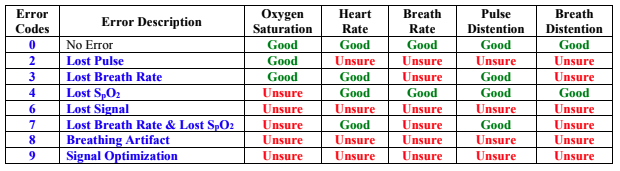

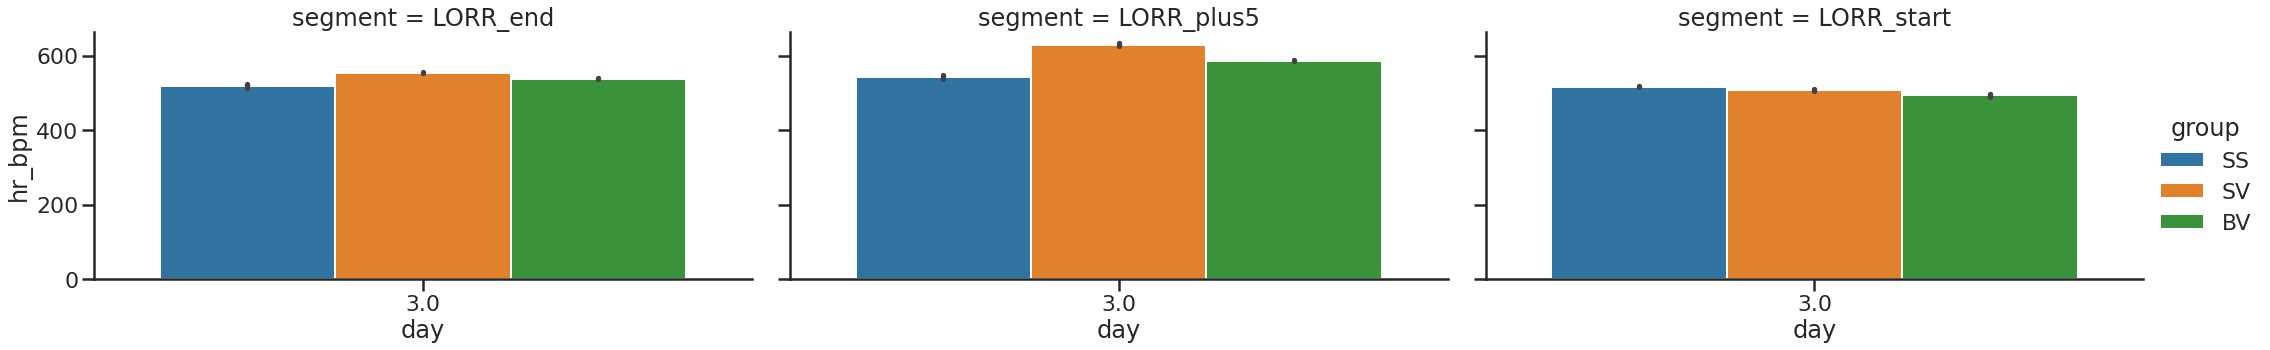

In [16]:
bad_codes = [2,6,8,9 ]
final_data_noerror = final_data[~final_data['error_code'].isin(bad_codes)]
final_data_noerror = final_data[final_data['error_code']==0]

sns.catplot(x='day', y='hr_bpm', data=final_data_noerror , kind='bar', hue='group', height=5, aspect=2, col='segment')

In [ ]:
bad_codes = [2,6,8,9 ]
final_data_noerror = final_data[~final_data['error_code'].isin(bad_codes)]

final_data_noerror = final_data_noerror[final_data_noerror['segment']=='LORR_plus5']
final_data_noerror = final_data_noerror[final_data_noerror['day']==3]

fig, ax = plt.subplots(figsize=(10,10))
sns.lineplot(x='level_0', y='hr_bpm', data=final_data_noerror, hue='group', ci=68)
plt.show()

In [ ]:
sns.countplot(x='error_code', data=data_final_clean)

In [ ]:
plt.figure(figsize=(15,5))
sns.catplot(x='error_code', data=data_final_clean[data_final_clean['time_sec']<60], kind='count',
              col='time_sec_round', col_wrap=5, sharex=False)

In [ ]:
data_final_clean[(data_final_clean['time_sec']<5)][0:100]

In [ ]:
def raster_error_code(data, animal, error_list, error_names):
    data_dict = {}
    colorCodes = ['C{}'.format(i) for i in range(len(error_list))]
    
    data_int = data_final_clean[data_final_clean['animal']==animal]

    for code in error_list:

        data_dict[code] = data_int[data_int['error_code'] == code]['time_sec'].values
        
    # Draw a spike raster plot
    plt.figure(figsize=(50,15))
    params = {'axes.labelsize': 75,
              'axes.titlesize': 75}
    plt.rc('xtick', labelsize=40) 
    plt.rc('ytick', labelsize=40) 
    plt.rcParams.update(params)
    plt.yticks(np.arange(0,len(error_list)), error_names) 
    plt.eventplot(data_dict.values(), color=colorCodes, linelengths = 0.3) 
    plt.xlabel('Time')
    plt.ylabel('Error Code')


    plt.show()    


In [ ]:
error_list = [0,2,3,4,6,7,8,9]
error_code = ['no_error', 'lost_pulse', 'lost_br', 'lost_SpO2', 'lost_signal', 'lost_br_SpO2', 'breath_arti', 'signal_opt']

for animal in data_final_clean['animal'].unique():
    print(animal)
    raster_error_code(data_final_clean, animal, error_list, error_code)


### Viz data

In [ ]:
data_final_clean.head()

,date,animal,time_sec,error_code,O2_sat,hr_bpm,br_brpm,pd_um,bd_um,activity,datetime,group,time_sec_round
2,050521,1370,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2021-05-05 14:25:48,bv,0.0
3,050521,1370,0.07,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2021-05-05 14:25:48,bv,0.0
4,050521,1370,0.13,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2021-05-05 14:25:48,bv,0.0
5,050521,1370,0.20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2021-05-05 14:25:48,bv,0.0
6,050521,1370,0.27,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2021-05-05 14:25:48,bv,0.0


In [ ]:
print(data_final_clean.shape)
data_hr = data_final_clean[data_final_clean['O2_sat']>0]
print(data_hr.shape)
code_drops = [2,3,4,6,8,9]
data_hr = data_hr[~data_hr['error_code'].isin(code_drops)]
#data_hr = data_hr[data_hr['time_sec']<400]
print(data_hr.shape)
data_hr.head()

(81020, 13)
(75168, 13)
(55971, 13)


,date,animal,time_sec,error_code,O2_sat,hr_bpm,br_brpm,pd_um,bd_um,activity,datetime,group,time_sec_round
339,050521,1370,22.47,0.0,92.1,669.0,209.0,153.8,0.0,0.0,2021-05-05 14:26:10,bv,22.0
340,050521,1370,22.53,0.0,92.1,669.0,209.0,153.8,0.0,0.0,2021-05-05 14:26:10,bv,23.0
341,050521,1370,22.60,0.0,92.1,669.0,209.0,153.8,0.0,0.0,2021-05-05 14:26:10,bv,23.0
342,050521,1370,22.67,0.0,92.1,667.0,209.0,153.8,0.0,0.0,2021-05-05 14:26:11,bv,23.0
343,050521,1370,22.73,0.0,92.1,667.0,209.0,153.8,0.0,0.0,2021-05-05 14:26:11,bv,23.0


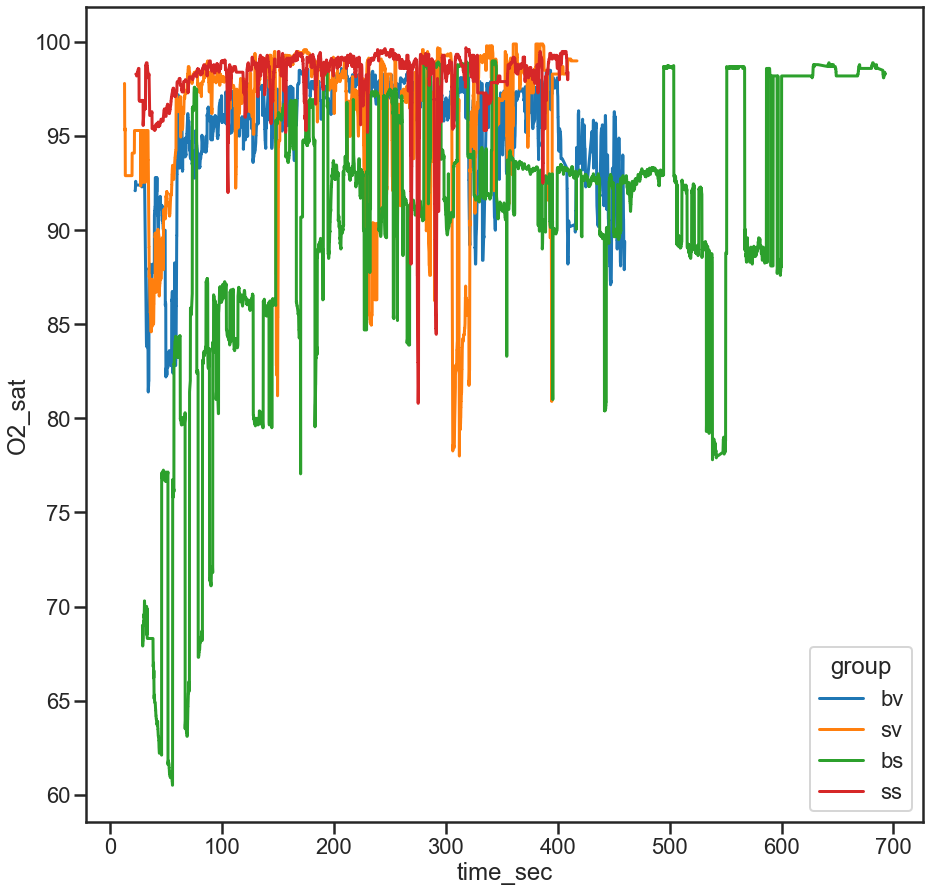

In [ ]:
plt.figure(figsize=(15,15))
sns.lineplot(x='time_sec', y='O2_sat', data=data_hr, ci=None, hue='group')
plt.show()